# Training

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data loader and preprocess

In [2]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 7.3 MB/s 
     |████████████████████████████████| 596 kB 59.9 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 77 kB 7.6 MB/s 
     |████████████████████████████████| 6.6 MB 54.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
import numpy as np
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset
from transformers import GPT2Tokenizer, GPT2Model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class VHRelationshipDataset(IterableDataset):
    def __init__(self, data_pth):
        self.json_file = os.path.join(data_pth, 'relationships')

    def __iter__(self):
        with open(self.json_file) as f:
            for sample_line in f:
                sample = json.loads(sample_line)
                yield sample

In [5]:
class VHDataloader:   
    class VHStructuredDataset(Dataset):
        def __init__(self, data_pth):
            self.data = {'goal': None, 
                        'history': None, 
                        'obs_ids': None, 
                        'obs_names': None,
                        'obs_states': None,
                        'obs_positions': None,
                        'char_label': None,
                        'action_label': None, 
                        'object_label': None}

            for key in self.data:
                self.data[key] = np.load(os.path.join(data_pth,"{}.npy".format(key)), allow_pickle=True)
                
        def __getitem__(self, index):
            goal = self.data['goal'][index]
            history = self.data['history'][index]
            obs_ids = self.data['obs_ids'][index]
            obs_names = self.data['obs_names'][index] 
            obs_states = self.data['obs_states'][index]
            obs_positions = self.data['obs_positions'][index]
            char_label = self.data['char_label'][index]
            action_label = self.data['action_label'][index]
            object_label = self.data['object_label'][index]

            return {'goal': goal,
                    'history': history,
                    'obs_ids': obs_ids,
                    'obs_names': obs_names,
                    'obs_states': obs_states,
                    'obs_positions': obs_positions,
                    'char_label':char_label,
                    'action_label':action_label,
                    'object_label':object_label}
            
        def __len__(self):
            return len(self.data['goal'])


    def __init__(self, data_pth, batch_size = 16, num_workers = 2):
        with open(os.path.join(data_pth, 'relationships'), 'r') as f:
            self.relationships =  json.load(f)
        self.structured_dataset = self.VHStructuredDataset(data_pth)
        self.dataloader = DataLoader(self.structured_dataset, 
                                     batch_size=batch_size, 
                                     num_workers=num_workers)
        self.batch_size = batch_size
    
    def __iter__(self): 
        for batch_n, sample in enumerate(self.dataloader):
            sample['relationships'] =  \
               self.relationships[batch_n*self.batch_size:(batch_n+1)*self.batch_size]
            yield sample
        

## Define preprocessing procedure

In [6]:
NUM_TOKENS = 50257
GOAL_LENGTH = 32
HISTORY_LENGTH = 128
NAMES_LENGTH = 256*2

def get_tokenizer(lm):
    tokenizer = GPT2Tokenizer.from_pretrained(lm)
    return tokenizer

def get_word_embeddings(lm):
    model = GPT2Model.from_pretrained(lm)
    word_embeddings = model.wte.weight
    return word_embeddings

#define tokenizer and embedders
pretrained_lm = 'gpt2'
tokenizer = get_tokenizer(pretrained_lm)
tokenizer.pad_token = tokenizer.eos_token
word_embeddings = get_word_embeddings(pretrained_lm).to(device)

def embed(sentence, tokenizer, word_embeddings, max_len=128):
    #list sentence arg can be like ['I have a pen', 'I have an apple']
    tokenized = tokenizer(sentence, max_length=max_len, pad_to_max_length=True, return_tensors="pt").input_ids.to(device)
    one_hot_tokenized = F.one_hot(tokenized, num_classes=NUM_TOKENS).type(torch.float32)
    embeddings = one_hot_tokenized @ word_embeddings
    return embeddings

def preprocess(data, tokenizer, embeddings):
    data['goal'] = embed(data['goal'], tokenizer, embeddings, max_len = GOAL_LENGTH)
    data['history'] = embed(data['history'], tokenizer, embeddings, max_len = HISTORY_LENGTH)
    data['obs_names'] = embed(data['obs_names'], tokenizer, embeddings, max_len = NAMES_LENGTH)
    data['obs_states'] = data['obs_states'].type(torch.float32).to(device)
    data['obs_positions'] = data['obs_positions'].type(torch.float32).to(device)
    data['char_label'] = data['char_label'].to(device).squeeze()
    data['action_label'] = data['action_label'].to(device).squeeze()
    data['object_label'] = data['object_label'].to(device).squeeze()
    return data

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

## Define Model

In [16]:
class LMDecisionMaker(nn.Module):
    def __init__(self):
        super().__init__()
        # define the layer in LM framework
        self.state_fc = nn.Linear(6, 768).to(device)
        self.position_fc1 = nn.Linear(6, 768).to(device)
        self.relu = nn.ReLU(inplace = True)
        self.position_fc2 = nn.Linear(768,  768).to(device)
        self.observation_fc = nn.Linear(3 * 768, 768).to(device) 
        self.action_fc = nn.Linear(768, 10).to(device)
        self.char_fc = nn.Linear(768, 2).to(device)
        self.object1_fc = nn.Linear(512, 512).to(device)
        self.object2_fc = nn.Linear(512, 512).to(device)
        self.lm = GPT2Model.from_pretrained(pretrained_lm).to(device)
    
    def lm_infer(self, input):
        return self.lm(inputs_embeds=input).last_hidden_state

    def forward(self, 
                goal, 
                history, 
                obs_ids, 
                obs_names, 
                obs_states, 
                obs_positions, 
                char_label, 
                action_label, 
                object_label, 
                relationships = [],
                mode='train'):
        
        goal_embeddings = goal
        
        history_embeddings = history
        
        name_embeddings = obs_names.unsqueeze(2)
        
        state_embeddings = self.state_fc(obs_states).unsqueeze(2)
        
        position_embeddings = self.position_fc2(self.relu(self.position_fc1(obs_positions))).unsqueeze(2)
        
        observation_embeddings = torch.cat((name_embeddings, state_embeddings, position_embeddings), 2)
        observation_embeddings = observation_embeddings.view(-1, NAMES_LENGTH, 3*768)
        observation_embeddings = self.observation_fc(observation_embeddings)
        observation_feature = self.lm_infer(observation_embeddings) # N*L*768
        
        contextualized_embeddings = torch.cat((goal_embeddings, history_embeddings, observation_embeddings),1)
        contextualized_embeddings = self.lm_infer(contextualized_embeddings)
        contextualized_feature = torch.mean(contextualized_embeddings, 1) # N*768
        
        char_scores = self.char_fc(contextualized_feature) # N * 2
        char_prediction = torch.argsort(char_scores, dim=1, descending=True) # N*10

        action_scores = self.action_fc(contextualized_feature) # N*10
        action_prediction = torch.argsort(action_scores, dim=1, descending=True) # N*10
        
        repeated_cf = contextualized_feature.unsqueeze(1).repeat(1,observation_feature.shape[1], 1)
        object_scores = torch.sum(observation_feature*repeated_cf, axis = -1) # N*L
        
        object_feature = torch.sum(observation_feature*repeated_cf, axis = -1) # N*L
        object1_scores = self.object1_fc(object_feature)
        object2_scores = self.object2_fc(object_feature)
        object1_prediction = torch.argsort(object1_scores, dim=1, descending=True)
        object2_prediction = torch.argsort(object2_scores, dim=1, descending=True)

        next_predicate = self.predictor(char_prediction, 
                                        action_prediction, 
                                        object1_prediction, 
                                        object2_prediction,
                                        obs_ids, 
                                        obs_names, 
                                        relationships)

        if mode == 'train':
            loss = self.compute_loss(char_scores, 
                                     action_scores, 
                                     object1_scores, 
                                     object2_scores,
                                     char_label,
                                     action_label, 
                                     object_label)
            
            accuracy = self.compute_accuracy(char_prediction[:,0], 
                                             action_prediction[:,0],
                                             object1_prediction[:,0],
                                             object2_prediction[:,0],
                                             char_label, 
                                             action_label, 
                                             object_label)
            # simple accuracy calculation, different from inference time
            return loss, accuracy

        return next_predicate

    def predictor(self, 
                  char_prediction,
                  action_prediction, 
                  object1_prediction,
                  object2_prediction, 
                  obs_ids,
                  obs_names, 
                  relationships = []):
        """
        Compute the loss and accuracy

        action_prediction: a torch tensor with a size (10), showing the probability of 10 actions
        object_prediction: a torch tensor with a size (len(observations)), showing the probability of all visible objects
        observations: a dictionary mapping the visible object (including all rooms) id to name, state vector and position vector
        relationships: a dictionary containing 4 relationship dictionary: sitting, close, inside, hold

        return: a predicate string in the form of VirtualHome format without character, e.g. '[walk] <chair> (1)'
        """
        pass

    def compute_loss(self, 
                     char_scores,
                     action_scores, 
                     object1_scores,
                     object2_scores,
                     char_label, 
                     action_label, 
                     object_label):
        """
        Compute the cross entropy loss
        scores: consists of action, char and label scores
        labels: consists of action, char and label label

        return: the cross entropy loss of the action and objects
        """ 
        char_loss = F.cross_entropy(char_scores, char_label) 
        action_loss = F.cross_entropy(action_scores, action_label) 
        object_loss = F.cross_entropy(object1_scores, object_label[:, 0]) \
                    + F.cross_entropy(object2_scores, object_label[:, 1]) 
                    # obj label 0 means no such object involved
        
        return char_loss + action_loss + object_loss # rescale for it is super big 

    def compute_accuracy(self,
                         char_pred, 
                         action_pred, 
                         object1_pred,
                         object2_pred,
                         char_label, 
                         action_label, 
                         object_label):
        """
        Compute the accuracy

        next_index: a tuple with three torch tensors with size (1), each indicates the index of the action and objects
        action label: a torch tensor of size (1), showing the true action label
        object label: a torch tensor of size (0) or (1) or (2), showing the true object labels

        return: the cross entropy loss of the action and objects
        """

        char_correct = torch.eq(char_pred, char_label).float()
        action_correct = torch.eq(action_pred, action_label).float()
        object1_correct = torch.eq(object1_pred, object_label[:,0]).float() 
        object2_correct = torch.eq(object2_pred, object_label[:,0]).float() 

        return 1/4*(char_correct.mean() \
             + action_correct.mean() \
             + object1_correct.mean() \
             + object2_correct.mean())
        


In [17]:
def train(net, train_loader, epochs = 20, batch_size = 16, learning_rate = 1e-3):
    """
    Train the input neural network for num_steps

    net: LM framework
    num_steps: number of batches to train for

    return: the trained net, the training accuracies per step, and the validation accuracies per steps
    """
    net = net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=learning_rate)
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        for batch_ndx, data in enumerate(train_loader):
            train_loss = torch.tensor([0], dtype=torch.float).to(device)
            train_accuracy = 0
            data = preprocess(data, tokenizer, word_embeddings)
            loss, acc = net.forward(**data)
            train_loss += loss / batch_size
            train_accuracy += acc.item() / batch_size
            opt.zero_grad()
            train_loss.backward()
            opt.step()
        if (epoch + 1) % 1 == 0:
            #val_loss, val_accuracy = validate(net, val_dataset)
            val_loss, val_accuracy = train_loss, train_accuracy
            print('step=%s   train(loss=%.5g, accuracy=%.5g)  val(loss=%.5g, accuracy=%.5g)' % (epoch + 1, train_loss, train_accuracy, val_loss, val_accuracy))
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss.item())
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)
    
    return net, \
          {'train':train_losses, 'val':val_losses},\
          {'train': train_accuracies, 'val':val_accuracies}

In [18]:
#define parameters and hyper parameters
data_pth = '/content/drive/MyDrive/Dataset/lm_vh/sample_data'
epochs = 10
batch_size = 4
learning_rate = 1e-3

In [19]:
#define loader
train_loader = VHDataloader(data_pth, batch_size = batch_size)

In [20]:
#define model
net = LMDecisionMaker()

In [ ]:
net, losses, accs = train(net, train_loader)

## Visualize training curve

No handles with labels found to put in legend.


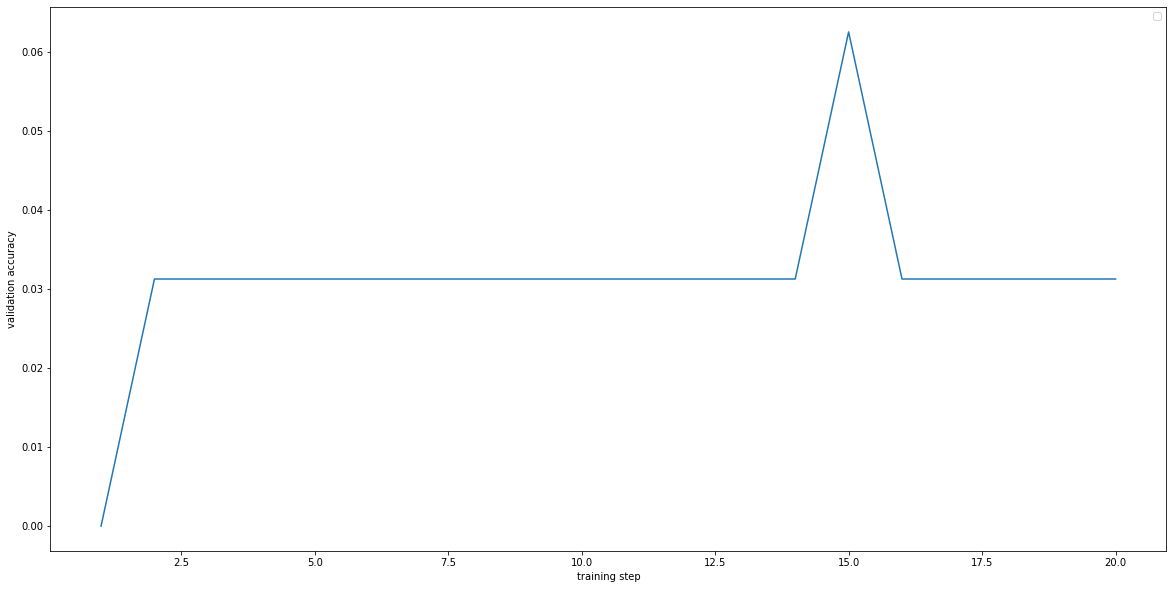

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot((1 + np.arange(len(accs['val']))), accs['val'])
plt.xlabel('training step')
plt.ylabel('validation accuracy')
plt.legend()
plt.show()

In [14]:
import gc 
with torch.no_grad():
    torch.cuda.empty_cache()
    gc.collect()

In [15]:
!nvidia-smi

Sun Apr 24 15:41:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    43W / 250W |   3193MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------